<a href="https://colab.research.google.com/github/AbbyNyakara/Mushroom-Classification/blob/main/STT_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Image Classification Project

# Team:
- Peter Imoukhuede
- Ezequiel Mussambe
- Abigael Mogusu




# PART 1 - Setup and Load data

In [52]:
# Import dependancies:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [26]:
# No gpu connected?? yikes
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
# Setup GPU memory consumption growth: Avoid the OOM error:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


#### Load the data

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Load data
# The classes of the data depends on the folder name

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/SmallData',
    batch_size=32
    )

Found 1573 files belonging to 2 classes.


## PART 2. DATA PREPROCESSING:
- Split the data
- Resize the images
- Normalize the Images
- Data Augmentation for edible class to be done on the fly as at the training

In [15]:
# Training set (70% of the data)
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.20,
#     subset="training",
#     seed=123
# )

# # Validation set( 15% of the data)
# validation_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.20,
#     subset="validation",
#     seed=123
# )

# # Testing set(15% of the data)
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.15,
#     subset="testing",
#     seed=123
# )



In [21]:
# Shuffle the images before splitting
# will cause memory overflow if the dataset too large??
#dataset = dataset.shuffle(buffer_size=1000)

In [30]:
# Alternatively:
train_size = int(len(dataset)*0.7)
test_size = int(len(dataset)*0.15)+1
validation_size = int(len(dataset)*0.15)+1



In [31]:
# Now split the data:

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)
val_ds = dataset.skip(train_size+test_size).take(validation_size)

len(train_ds)
# The train is about 629 batches

35

In [32]:

# Print the classNames:
class_names = dataset.class_names
print(class_names)

['Edible Mushrooms', 'Inedible Mushrooms']


In [33]:
# 1. Resize the images:

size = (256, 256)

# Use a labda function to resize all the images for both the training and validatioon sets:
train_ds1 = train_ds.map(lambda image, label:(tf.image.resize(image, size), label))
validation_ds1 = val_ds.map(lambda image, label:(tf.image.resize(image, size), label))

In [34]:
# Normalize the images to a common value:
train_ds = train_ds1.map(lambda image, label: (image/255.0, label))
validation_ds = validation_ds1.map(lambda image, label: (image/255.0, label))


Image Segmentation/Remove Background:

# 3. Exploratory Data Analysis (EDA)

- Check for any outliers in the images
- Display a few random images
- Imbalances in the data:

## 3.1 Display the images:

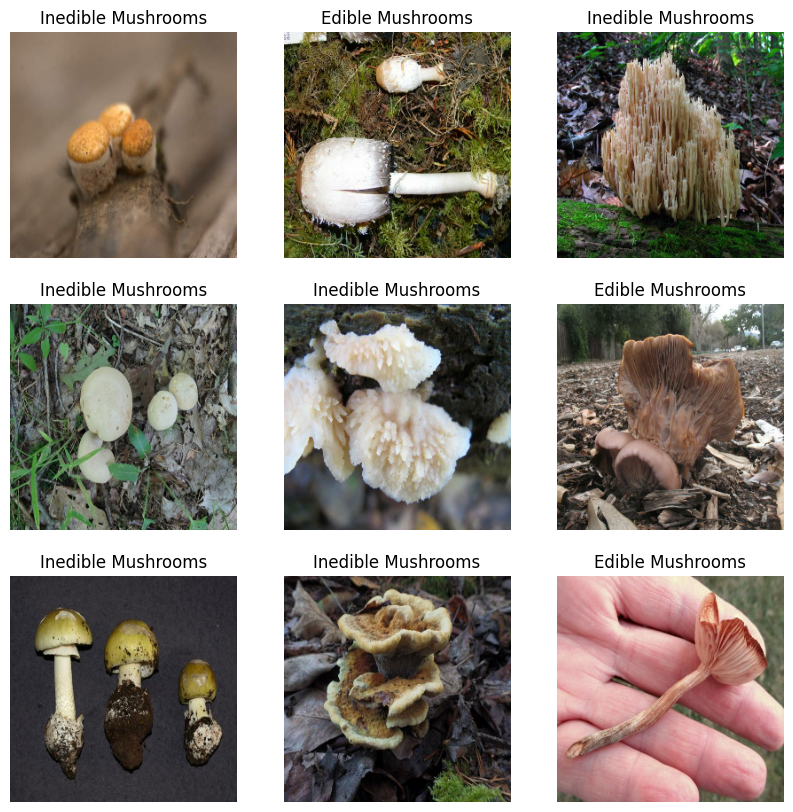

In [14]:
# Display original images :

# The dataset is very highly imbalanced. Only picking the inedbile images??
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 3.2 Check for outliers

In [35]:

pixel_sums = 0
pixel_sums_squared = 0
num_samples = 0

# Iterate over unbatched dataset to calculate mean and std
for images, _ in train_ds.unbatch():
  pixel_sums += tf.reduce_sum(images, axis=[0, 1, 2])
  pixel_sums_squared += tf.reduce_sum(tf.square(images), axis=[0, 1, 2])
  num_samples += images.shape[0]

# Calculate mean and standard deviation
mean = pixel_sums / num_samples
std = tf.sqrt((pixel_sums_squared / num_samples) - tf.square(mean))

# Define a function to detect outliers
def is_outlier(image, mean, std, threshold=3):
    distance_from_mean = tf.abs(image - mean)
    return tf.reduce_any(distance_from_mean > (threshold * std))

# Collect outliers
outliers = [(image, label) for image, label in train_ds.unbatch() if is_outlier(image, mean, std)]

# Print the number of outliers
print(f"Number of outlier images: {len(outliers)}")

# Visualize outliers
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(outliers[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
plt.show()


Number of outlier images: 0


<Figure size 1000x1000 with 0 Axes>

## 3.3 Checking for imbalances in the data:

In [36]:
# Check number of images in each class/ imbalances in the data:

class_counts = {}
for images, labels in dataset:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

for class_name, count in class_counts.items():
  print(f"Class: {class_name}, Count: {count}")

Class: Inedible Mushrooms, Count: 1315
Class: Edible Mushrooms, Count: 258


# 4. Convolutional Neural Network Model:

## 4.1 Build the deep learning model

In [37]:
# Define the model:
model = Sequential()

In [38]:
# Add the layers:

model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [39]:
# Compile the model:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## 4.2 Train the model:

In [41]:
log_directory = '/content/drive/MyDrive/Statistics/Project/logs'

In [42]:
# This is to log the model as it trains: (To check how it performs as it trains)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

### Save the training history

In [43]:
hist = model.fit(train_ds, epochs=20, validation_data = val_ds, callbacks=tensorboard_callback)

Epoch 1/20
35/35 [==============================] - 9s 90ms/step - loss: 0.7119 - accuracy: 0.8339 - val_loss: 53.3305 - val_accuracy: 0.8579
Epoch 2/20
35/35 [==============================] - 4s 108ms/step - loss: 0.4713 - accuracy: 0.8330 - val_loss: 69.1917 - val_accuracy: 0.8071
Epoch 3/20
35/35 [==============================] - 4s 111ms/step - loss: 0.4707 - accuracy: 0.8348 - val_loss: 30.3025 - val_accuracy: 0.8528
Epoch 4/20
35/35 [==============================] - 4s 107ms/step - loss: 0.4523 - accuracy: 0.8411 - val_loss: 76.5177 - val_accuracy: 0.8325
Epoch 5/20
35/35 [==============================] - 4s 109ms/step - loss: 0.4330 - accuracy: 0.8420 - val_loss: 46.1646 - val_accuracy: 0.8223
Epoch 6/20
35/35 [==============================] - 4s 110ms/step - loss: 0.4221 - accuracy: 0.8375 - val_loss: 59.8255 - val_accuracy: 0.8223
Epoch 7/20
35/35 [==============================] - 4s 108ms/step - loss: 0.4003 - accuracy: 0.8384 - val_loss: 77.1707 - val_accuracy: 0.7919


## Plot the perfomance:

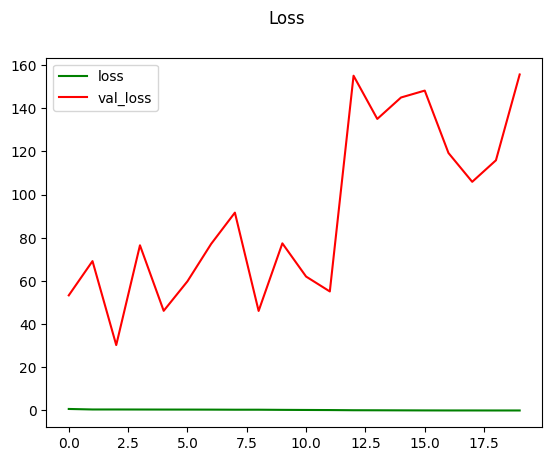

In [49]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

- The model is pretty awful!!
- Nte: The loss should be a steady decrease: Not what we are seeing!!

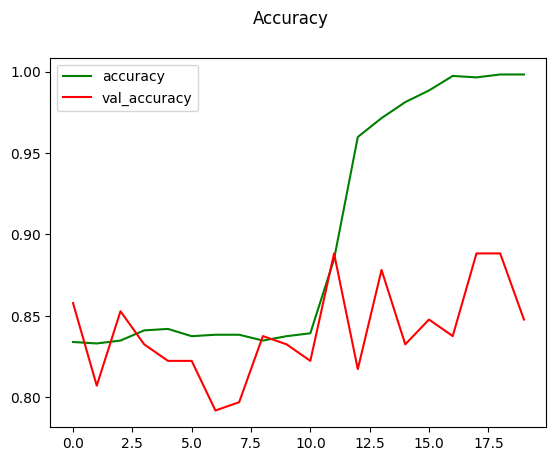

In [50]:
# Plot the accuracy:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
plt.suptitle('Accuracy')
plt.legend()
plt.show()



# 4. Evaluate the Perfomance:

## 4.1 Evaluate the precision, accuracy and the Binary accuracy: (Highest 1, lowest =0)

In [57]:
# Precision, recalla nd binary accuracy:

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

In [58]:
for batch in test_ds:
  images, labels = batch
  predictions = model.predict(images)
  precision.update_state(labels, predictions)
  recall.update_state(labels, predictions)
  binary_accuracy.update_state(labels, predictions)

1/1 [==============================] - 0s 29ms/step


In [60]:
# Precision, accuracy and binary accuracy:
print(precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy())

0.91943127 0.9238095 0.87109375


## 4.2 Evaluate the model on a new unseen images:

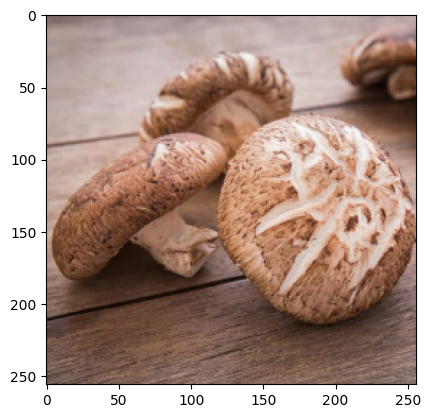

In [67]:
# Import an edible image downloaded from the internet:

img2 = cv2.imread('/content/drive/MyDrive/Statistics/Project/ediblemushroom_test.jpg')
# import the image in its original form:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (256, 256))
plt.imshow(img2)
plt.show()

In [69]:
np.expand_dims(img2, axis=0).shape

(1, 256, 256, 3)

In [71]:
y_pred = model.predict(np.expand_dims(img2/255, axis=0))
y_pred

1/1 [==============================] - 0s 24ms/step


array([[0.9911374]], dtype=float32)

# Rename the edible to 1 and inedible to 0
- TODO!

# 5. SAVE THE MODEL:

## 5.1 Test the used model:

In [74]:
model.save('/content/drive/MyDrive/Statistics/Project/mushroomModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
SavedModel = '/content/drive/MyDrive/Statistics/Project/SavedModel'
model.save(os.path.join(SavedModel, "mushroomModel.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
# Load the saved model and try to use it again??
model_path = os.path.join(SavedModel, "mushroomModel.h5")
new_model = tf.keras.models.load_model(model_path)

In [82]:
# The model is saved and can be used..
new_model.predict(np.expand_dims(img2/255, axis=0))

1/1 [==============================] - 0s 81ms/step


array([[0.9911374]], dtype=float32)